## 0. Import libraries

In [921]:
import torch
import pandas as pd
import numpy as np
import math, copy, time
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset 
from torch.optim import Adam
import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

## 1. Load Data

In [922]:
df = pd.read_csv('./kospi.csv')
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
6758,2024-05-17,2751.469971,2752.169922,2724.620117,2724.620117,2724.620117,575900
6759,2024-05-20,2741.239990,2756.409912,2734.639893,2742.139893,2742.139893,582100
6760,2024-05-21,2733.030029,2734.479980,2719.739990,2724.179932,2724.179932,560800
6761,2024-05-22,2723.459961,2733.070068,2707.870117,2723.459961,2723.459961,484700
6762,2024-05-23,2719.030029,2734.270020,2704.000000,2721.810059,2721.810059,428079


In [923]:
df = df.loc[:, ['Date', 'Adj Close']]
df['kospi_shift'] = df['Adj Close'].shift(-1)
df.columns = ['Date', 'kospi', 'kospi_shift']

df.head()

,Date,kospi,kospi_shift
0,1996-12-11,704.679993,689.380005
1,1996-12-12,689.380005,689.070007
2,1996-12-13,689.070007,673.919983
3,1996-12-16,673.919983,663.349976
4,1996-12-17,663.349976,661.390015


In [924]:
col_names = df.columns.values
print(col_names)

['Date' 'kospi' 'kospi_shift']


In [925]:
df['kospi_diff'] = df['kospi_shift'] - df['kospi']
df['kospi_diff'] = df['kospi_diff'].apply(lambda x: 0 if x < 0 else 1)
df.tail()

,Date,kospi,kospi_shift,kospi_diff
6758,2024-05-17,2724.620117,2742.139893,1
6759,2024-05-20,2742.139893,2724.179932,0
6760,2024-05-21,2724.179932,2723.459961,0
6761,2024-05-22,2723.459961,2721.810059,0
6762,2024-05-23,2721.810059,NaN,1


In [926]:
# df = df.drop(['kospi_shift'], axis=1)
# df.tail()

In [927]:
# global variables and hyperparameter
IN_DIM = 128
DAY_INT = 1
BATCH_SIZE = 64
SCALER = 'MINMAX'   # 'NORMAL'
# SCALER = 'NORMAL'   # 'NORMAL'
TRAIN_TEST_SPLIT = 0.95
LR = 1e-4

## 2. Split data train and test

In [928]:
# train test split
df_train = df.iloc[:int(len(df) * TRAIN_TEST_SPLIT), :]
df_test = df.iloc[int(len(df) * TRAIN_TEST_SPLIT): , :]
# print(df_train.tail())
# print(df_test.head())
print(col_names)

scale_params = pd.DataFrame(index=['mean', 'var', 'max', 'min'])
# print(scale_params)
for i in col_names[1:-1]:
    # print(df_train[i])
    scale_params[i] = [df_train[i].mean(), df_train[i].var(), df_train[i].max(), df_train[i].min()]
scale_params

['Date' 'kospi' 'kospi_shift']


,kospi
mean,1566.202960
var,515801.468025
max,3305.209961
min,280.000000


In [929]:
# scaling
train_data = pd.DataFrame()
test_data = pd.DataFrame()
col_range = col_names[1:-1]
# col_range = ['currency', 'kospi']
if SCALER == 'MINMAX':
    for i in col_range:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['min', i])/(scale_params.loc['max', i] - scale_params.loc['min', i]))
elif SCALER == 'NORMAL':
    for i in col_range:
        train_data[i] = df_train[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
        test_data[i] = df_test[i].apply(lambda x: (x - scale_params.loc['mean', i])/scale_params.loc['var', i])
train_data = pd.concat([train_data['kospi'], pd.get_dummies(df_train['kospi_diff'].astype('str')).astype('float')], axis=1)
# test_data['kospi_diff'] = df_test['kospi_diff']
test_data = pd.concat([test_data['kospi'], pd.get_dummies(df_test['kospi_diff'].astype('str')).astype('float')], axis=1)
test_data.tail()

,kospi,0,1
6758,0.808083,0.0,1.0
6759,0.813874,1.0,0.0
6760,0.807937,1.0,0.0
6761,0.807699,1.0,0.0
6762,0.807154,0.0,1.0


In [930]:
class StockDataset(Dataset):
    def __init__(self, x, y, input_window=128, output_window=1, stride=1):
        #총 데이터의 개수
        L = y.shape[0]
        #stride씩 움직일 때 생기는 총 sample의 개수
        num_samples = (L - input_window - output_window) // stride + 1
        start_pos = (L - input_window - output_window) % stride
        iter_times = (L - input_window - output_window) // stride + 1
        print(y.shape, num_samples, iter_times, start_pos, L)

        #input과 output
        X = np.zeros([input_window, num_samples])
        Y = np.zeros([output_window, num_samples, y.shape[1]])

        for i in np.arange(num_samples):
            start_x = start_pos + i * stride
            end_x = start_x + input_window
            X[:,i] = x[start_x:end_x]

            # end_y = start_y + output_window
            # print(i, start_x, end_x)
            Y[:,i] = y.iloc[end_x: end_x + output_window, :]
        # print(X.shape, Y.shape)
        X = X.reshape(X.shape[0], X.shape[1], 1).transpose((1,0,2))
        Y = Y.reshape(Y.shape[0], Y.shape[1], 2).transpose((1,0,2))
        print(X.shape, Y.shape)
        self.x = X
        self.y = Y
        
        self.len = len(X)
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    def __len__(self):
        return self.len

In [931]:
print(train_data.iloc[0:3, :])
train_dataset = StockDataset(train_data['kospi'], train_data.loc[:, ['0', '1']], 128, 1, 1)
# (5072, 5)

      kospi    0    1
0  0.140380  1.0  0.0
1  0.135323  1.0  0.0
2  0.135220  1.0  0.0
(6424, 2) 6296 6296 0 6424
(6296, 128, 1) (6296, 1, 2)


### 3. create dataloader

In [932]:
train_dataset = StockDataset(train_data['kospi'], train_data.loc[:, ['0', '1']], 128, 1, 1)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = StockDataset(test_data['kospi'], test_data.loc[:, ['0', '1']], 128, 1, 1)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
a1 = next(iter(train_dataset))
print(len(train_dataloader), len(train_dataloader.dataset), a1[0].shape, a1[1].shape)
# print(a1)

(6424, 2) 6296 6296 0 6424
(6296, 128, 1) (6296, 1, 2)
(339, 2) 211 211 0 339
(211, 128, 1) (211, 1, 2)
99 6296 (128, 1) (1, 2)


## 4. Make a Transformer model

In this sections, we will implement the building blocks of the transformer: [Positional encoding](#1a), [Multi-head attention](#1b) and [Position wise feedforward network](#1c)

### a. Sinusoidal Positional Encoding
<a id='1a'></a>
In this section, we will implement sinusoidal positional encoding

$$\begin{align}
PE(pos, 2i) &= \sin \left( pos / 10000^{2i / d_{model}} \right)  \\
PE(pos, 2i+1) &= \cos \left( pos / 10000^{2i / d_{model}} \right)  
\end{align}$$

In [933]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model , max_len, device):
        """
        d_model: dimension of model
        max_len: maximum sequence length
        device: 'cuda' or 'cpu'
        """
        super().__init__()
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.required_grad = False

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1) # [a, b, ...] -> [[a], [b], [c], ...]

        _2i = torch.arange(0, d_model, step=2, device=device) # i is d_model and step=2 means 2*i
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
    
    def forward(self, x):
        # x: Tensor, shape ``[batch_size, seq_len, embedding_dim]
        # d_model = 512
        # print(x.size())
        batch_size, seq_len = x.size()[:2]
        pe = self.encoding[:seq_len, :]
        return pe

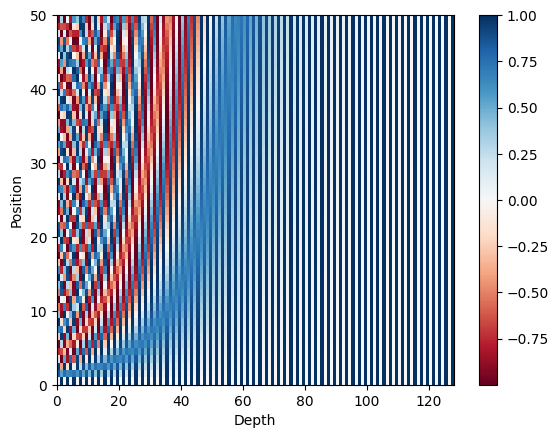

In [934]:
sample_pos_encoding = PositionalEncoding(128, 50, device='cpu')

plt.pcolormesh(sample_pos_encoding.encoding.numpy(), cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()


### b. Scaled dot product attention

__Scaled dot product:__
![picture](./assets/transformer_2.png)

In [935]:
class ScaleDotProductAttention(nn.Module):
    """
    Query: given setence
    Key: same with query(encoder)
    Value: same with key
    """

    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None, e=1e-12):
        # input: 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. q @ K.T
        k_t = k.transpose(2, 3)
        score = (q @ k_t) / math.sqrt(d_tensor)

        # 2. masking(decoder self attention only)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)
        
        # 3. pass them softmax to [0, 1] range
        score = self.softmax(score)

        # 4. multiply with value
        v = score @ v

        return v, score

### c. MultiheadAttention
<a id='1b'></a>
Equation:

$$\begin{align} \text{MultiHead}(Q, K, V) &= \text{Concat}(head_1, ...., head_h) W^O \\
\text{where head}_i &= \text{Attention} \left( QW^Q_i, K W^K_i, VW^v_i \right)
\end{align}$$

In [936]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super().__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)
    
    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. scale dot product
        out, attention = self.attention(q, k, v, mask=mask)

        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        return out
    
    def split(self, tensor):
        '''
        split tensor by heads
        tensor: [batch_size, seq_len, d_model]
        return: [batch_size, head, seq_len, d_tensor] --- d_model = head * d_tensor
        '''
        batch_size, seq_len, d_model = tensor.size()
        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, seq_len, self.n_head, d_tensor).transpose(1, 2)
        # split by # of heads
        return tensor
    
    def concat(self, tensor):
        '''
        inverse of split(tensor)
        tensor: [batch_size, head, seq_len, d_tensor]
        return: [batch_size, seq_len, d_model]
        '''
        batch_size, head, seq_len, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)
        return tensor
        

### d. Position-wise feed forward network
<a id='1c'></a>
In this section, we will implement position-wise feed forward network

$$\text{FFN}(x) = \max \left(0, x W_1 + b_1 \right) W_2 + b_2$$

In [937]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, hidden, dropout):
        super().__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

### e. Layer Normalization

In [938]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True)
        # -1 to get mean and var for the last dimension(d_model)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

## 5. Embedding input data

make 1 input dimension data to d_model dimentions

In [939]:
class LinearEmbedding(nn.Module):
    def __init__(self, dropout, d_model):
        '''
        data: [batch_size, seq_len, 1]
        In this model, only kospi input window
        '''
        super().__init__()
        self.d_model = d_model
        self.linear1 = nn.Linear(1, d_model//2)
        self.linear2 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout)
        self.layernorm1 = LayerNorm(d_model//2)
        self.layernorm2 = LayerNorm(d_model)
    
    def forward(self, x):
        '''
        input: [batch_size, seq_len, 1]
        output: [batch_size, seq_len, d_model]
        '''
        batch_size, sel_len, x_len = x.size()
        cls_token = torch.rand((x.size()[0], x.size()[1], x.size()[-1]), device=x.device)
        # print(cls_token.size(), x.size()) # torch.Size([64, 128, 1]) torch.Size([64, 128, 1])
        # for i in range(batch_size):
        #     print(x[i, :2, :])
        # x = torch.concat([cls_token, x], dim=2) # add CLS token for attention. pos [ , , , -1]
        x[:, 0, 0] = cls_token[:, 0, 0]
        # print(x.size())
        # for i in range(batch_size):
        #     print(x[i, :2, :])
        # residual = x
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layernorm1(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.layernorm2(x)
        # print('linear embedding output shape:', x.size())
        return x


In [940]:
class EmbeddingAttention(nn.Module):
    def __init__(self, model_d):
        super().__init__()
        self.w_q = nn.Linear(model_d, model_d)
        self.w_k = nn.Linear(model_d, model_d)
        self.w_v = nn.Linear(model_d, model_d)
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, q, k, v, mask=None, e=1e-12):
        # q: 4 dimension tensor
        # [batch_size, seq_len, length, model_d] q length is 1 and k, v length is 4
        batch_size, seq_len, length, model_d = k.size()
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 1. q @ K.T
        k_t = k.transpose(2, 3)
        # print('q_size:', q.size(), ' , k_t_size:', k_t.size())
        score = (q @ k_t) / math.sqrt(model_d)

        # 2. masking(decoder self attention only)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)
        
        # 3. pass them softmax to [0, 1] range
        score = self.softmax(score)

        # 4. multiply with value
        v = score @ v

        return v, score

In [941]:
class TrnasformerEmbedding(nn.Module):
    '''
    d_model: dimension of input data
    seq_len: max length of sequence
    '''
    def __init__(self, dropout, d_model, seq_len, device):
        super().__init__()
        self.lin_emb = LinearEmbedding(dropout, d_model)
        self.emb_attn = EmbeddingAttention(d_model)
        self.pos_emb = PositionalEncoding(d_model, seq_len, device)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        lin_emb = self.lin_emb(x)
        # attn_emb, score = self.emb_attn(lin_emb[:, :, -1, :].unsqueeze(2), lin_emb[:, :, :-1, :], lin_emb[:, :, :-1, :])
        # attn_emb = attn_emb.squeeze(2)
        pos_emb = self.pos_emb(x)
        # print('attn_emb:', attn_emb.size())
        # print('pos_emb:', pos_emb.size())
        return self.dropout(lin_emb + pos_emb)

## 6. Encoder Layer
Trnasformer Encoder Except Embedding

In [942]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, ffn_hidden, n_head, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        # self.normal1 = LayerNorm(d_model=d_model)
        self.normal1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=dropout)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, dropout=dropout)
        # self.normal2 = LayerNorm(d_model=d_model)
        self.normal2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=dropout)
    
    def forward(self, x, src_mask=None):
        # 1. multihead Attention
        residual = x
        x = self.attention(x, x, x)

        # 2. add and norm
        x = self.dropout1(x)
        x = self.normal1(x + residual)

        # 3. positionwise FFN
        residual = x
        x = self.ffn(x)

        # 4. add and norm
        x = self.dropout2(x)
        x = self.normal2(x + residual)

        return x

## 7. Encoder
Build Embedding and Encoder Block

In [943]:
class Encoder(nn.Module):
    def __init__(self, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        super().__init__()
        self.emb = TrnasformerEmbedding(dropout, d_model, seq_len, device)
        self.layers = nn.ModuleList([EncoderLayer(d_model, ffn_hidden, n_head, dropout)
                                     for _ in range(n_layers)])
    
    def forward(self, x):
        x = self.emb(x)
        for layer in self.layers:
            x = layer(x)
        
        return x

## 8. Transformer Encoder
Only use encoder module and FFN 

In [944]:
class TransformerEncoder(nn.Module):
    def __init__(self, seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device):
        super().__init__()
        self.encoder = Encoder(seq_len, d_model, ffn_hidden, n_head, dropout, n_layers, device)
        # self.flatten = nn.Flatten()
        self.flatten_dim = seq_len * d_model
        self.linear1 = nn.Linear(d_model, d_model // 2)
        self.linear2 = nn.Linear(d_model // 2, d_model // 4)
        self.linear3 = nn.Linear(d_model // 4, 2)   # binary classification
        self.layernorm1 = nn.LayerNorm(d_model // 2)        
        self.layernorm2 = nn.LayerNorm(d_model // 4)        

        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.encoder(x)
        # x = self.encoder(x)[:, 0, :]
        # x = self.flatten(x)
        # print(x.size())
        x = self.linear1(x)[:, 0, :]
        # x = self.linear1(x)
        # print(x.size())
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layernorm1(x)
        
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layernorm2(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        
        return x

## 9. model, loss_fn, optimizer


In [945]:
# next(iter(train_dataloader)).shape
# torch.cuda.empty.cache()
batch_size, seq_len, input_dim = next(iter(train_dataloader))[0].size()
print(batch_size, seq_len, input_dim)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_d = 512
dropout = 0.2
ffn_hidden = model_d // 2
n_layers = 4
n_head = 2
lr = 1e-3
lr_sched = True

64 128 1


In [946]:
model = TransformerEncoder(seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr = lr)
if lr_sched == True:
    # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
    #                                     lr_lambda=lambda epoch: 0.95 ** epoch,
    #                                     last_epoch=-1,
    #                                     verbose=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [947]:
model

TransformerEncoder(
  (encoder): Encoder(
    (emb): TrnasformerEmbedding(
      (lin_emb): LinearEmbedding(
        (linear1): Linear(in_features=1, out_features=256, bias=True)
        (linear2): Linear(in_features=256, out_features=512, bias=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.2, inplace=False)
        (layernorm1): LayerNorm()
        (layernorm2): LayerNorm()
      )
      (emb_attn): EmbeddingAttention(
        (w_q): Linear(in_features=512, out_features=512, bias=True)
        (w_k): Linear(in_features=512, out_features=512, bias=True)
        (w_v): Linear(in_features=512, out_features=512, bias=True)
        (softmax): Softmax(dim=-1)
      )
      (pos_emb): PositionalEncoding()
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (layers): ModuleList(
      (0-3): 4 x EncoderLayer(
        (attention): MultiHeadAttention(
          (attention): ScaleDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (w_q): Linear(in_

## 10. Train and Test function

In [948]:
linear_model = LinearEmbedding(0.2, model_d).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = linear_model(in_x)
out.size()
print(in_x.size())
print(out.size())

torch.Size([64, 128, 1])
torch.Size([64, 128, 512])


In [949]:
# a = torch.rand((64, 128, 1, 1024))
# b = torch.rand((64, 128, 1024, 4))
# c = a @ b
# print(a[:, :, -1, :].unsqueeze(2).size())
# c.size()

In [950]:
emb_model = TrnasformerEmbedding(0.2, model_d, seq_len, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = emb_model(in_x)
out.size()

torch.Size([64, 128, 512])

In [951]:
encoder_model = Encoder(seq_len, model_d, ffn_hidden, n_head, dropout, n_layers, device).to(device)
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = encoder_model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 128, 512])
torch.Size([64, 1, 2])
torch.Size([128])


In [952]:
in_x, in_y = next(iter(train_dataloader))
in_x = in_x.to(device).float()
out = model(in_x)
print(out.size())
print(in_y.shape)
print(in_y.contiguous().view(-1).shape)

torch.Size([64, 2])
torch.Size([64, 1, 2])
torch.Size([128])


In [953]:
print(out[:10])
print(in_y[:10])
loss = loss_fn(out[0].float(), in_y[0][0].to(device).float())
loss.item()

tensor([[0.3062, 0.6016],
        [0.5675, 0.6609],
        [0.5663, 0.3908],
        [0.2851, 0.3095],
        [0.3969, 0.4494],
        [0.2195, 0.5150],
        [0.3091, 0.3302],
        [0.3398, 0.6113],
        [0.4933, 0.5500],
        [0.4943, 0.5579]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[[0., 1.]],

        [[0., 1.]],

        [[0., 1.]],

        [[1., 0.]],

        [[1., 0.]],

        [[1., 0.]],

        [[1., 0.]],

        [[1., 0.]],

        [[1., 0.]],

        [[0., 1.]]], dtype=torch.float64)


0.5563235878944397

In [954]:
epochs = 1000
loss_np = np.zeros((epochs, 2))
df_loss = pd.DataFrame(loss_np, columns=['epoch', 'loss'])
for i in range(epochs):
    epoch_loss = 0
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device).float()
        labels = labels.to(device)
        # print(inputs.size(), labels.size())

        optimizer.zero_grad()
        output = model(inputs)
        # print(output.size())
        loss = loss_fn(output.squeeze(1).float(), labels.squeeze().float())
        # print(loss)
        loss.backward()
        # torch.nn.utils.clip_grad_norm(model.parameters(), 0.5)  # when using scheduler, it is not for grad exploding
        optimizer.step()

        epoch_loss += loss.item()
    
    print(f'epochs: {i}, loss: {epoch_loss:.6f}, lr: ', round(optimizer.param_groups[0]['lr'], 8))
    if lr_sched == True:
        scheduler.step()
    df_loss.loc[i, :] = [i, epoch_loss]

epochs: 0, loss: 68.716323, lr:  0.001
epochs: 1, loss: 68.529038, lr:  0.001
epochs: 2, loss: 68.464493, lr:  0.001
epochs: 3, loss: 68.464252, lr:  0.001


KeyboardInterrupt: 

In [ ]:
# save_path = 'transormer_cts_token_kospi_only_model_d_' + str(model_d) +'seqlen' + str(seq_len) + '_layaers' + str(n_layers) + '_nhead' + str(n_head) + '.pt'
# # save_path = 'kospi_only.pt'
# torch.save(model.state_dict(), save_path)
# print(save_path)
# df_loss

transormer_kospi_w_other_window_model_d512seqlen128_layaers4_nhead2.pt


,epoch,loss
0,0.0,54.829432
1,1.0,53.956519
2,2.0,53.945283
3,3.0,53.934084
4,4.0,53.942394
...,...,...
95,95.0,53.924703
96,96.0,53.921212
97,97.0,53.927131
98,98.0,53.931064


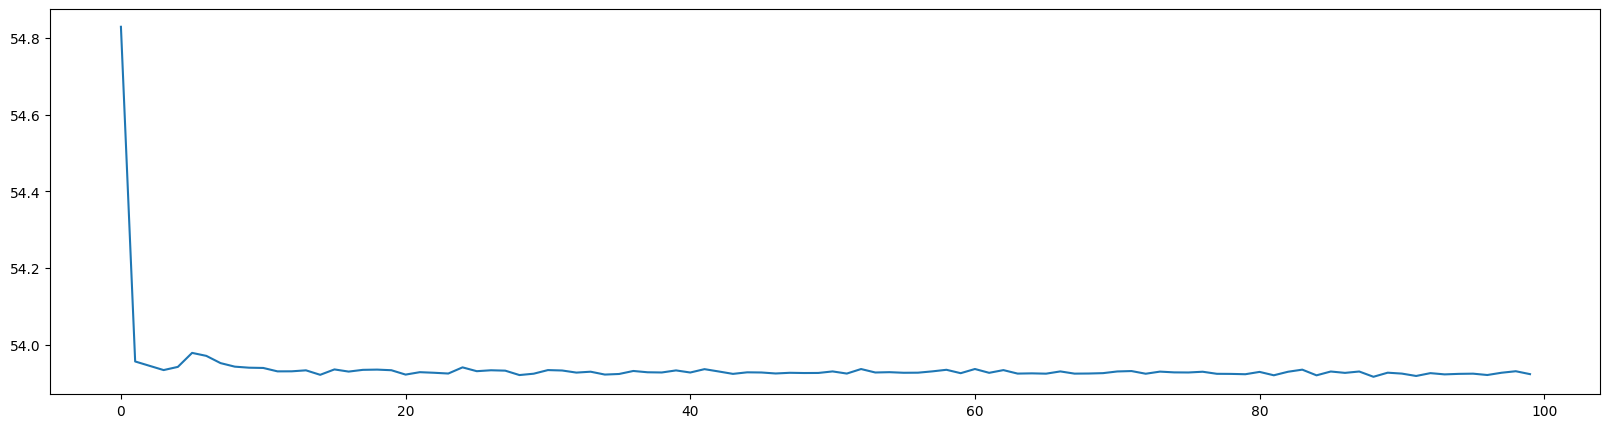

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(df_loss.loc[:, 'epoch'], df_loss.loc[:, 'loss'])
plt.show()

In [ ]:
test_result = pd.DataFrame(columns=['pred', 'real'])
num = 0

with torch.no_grad():
    for _, data in enumerate(test_dataloader):
        inputs = data[0].to(device).float()
        # outputs = data[1].to(device).float()
        outputs = data[1].squeeze()
        
        pred = model(inputs)
        for i in range(len(pred)):
            pred_ = pred.detach().cpu().numpy()[i][0]
            # pred_ = 1 if pred_ > 0.5 else 0
            # print(out_scaled)
            test_result.loc[num] = [pred_, outputs[i].cpu().numpy()]
            num += 1

In [ ]:
test_result['pred_'] = np.where(test_result['pred']> 0.5, 1 , 0)

In [ ]:
test_result

,pred,real,pred_
0,0.470366,0.6669077351054039,0
1,0.470366,0.6582677012568363,0
2,0.470366,0.6603793654134782,0
3,0.470366,0.6536420387917257,0
4,0.470366,0.6513602253411171,0
...,...,...,...
135,0.470366,0.7776665218776749,0
136,0.470366,0.7776665218776749,0
137,0.470366,0.7864303435866145,0
138,0.470366,0.7754542977886941,0


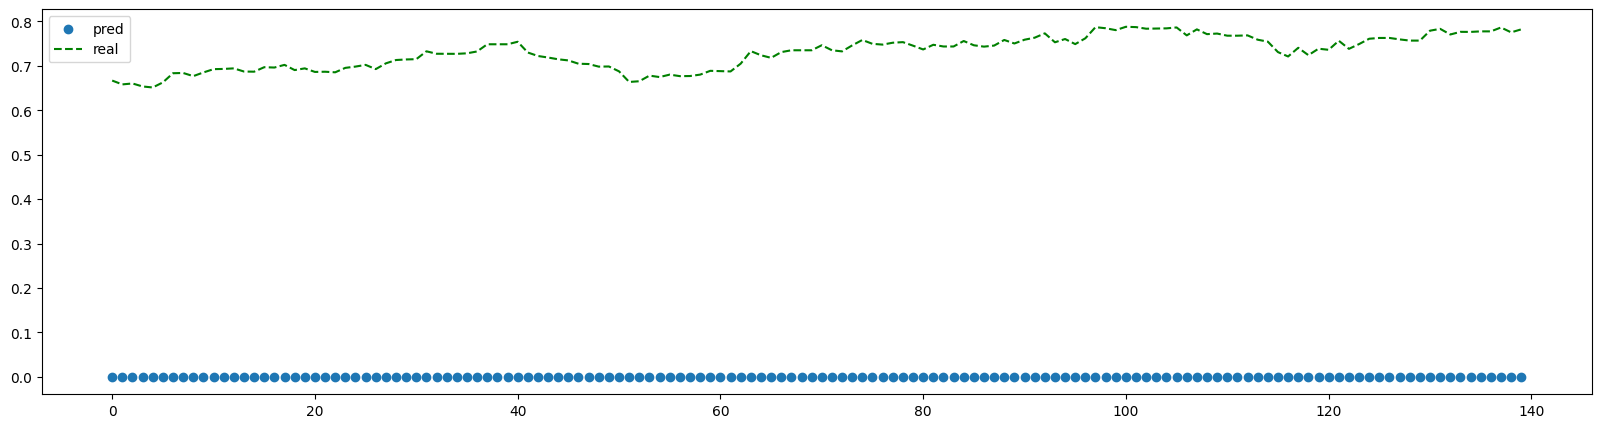

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['pred_rescale'], label='pred')
plt.scatter(range(len(test_result)), test_result['pred_'], label='pred')
plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

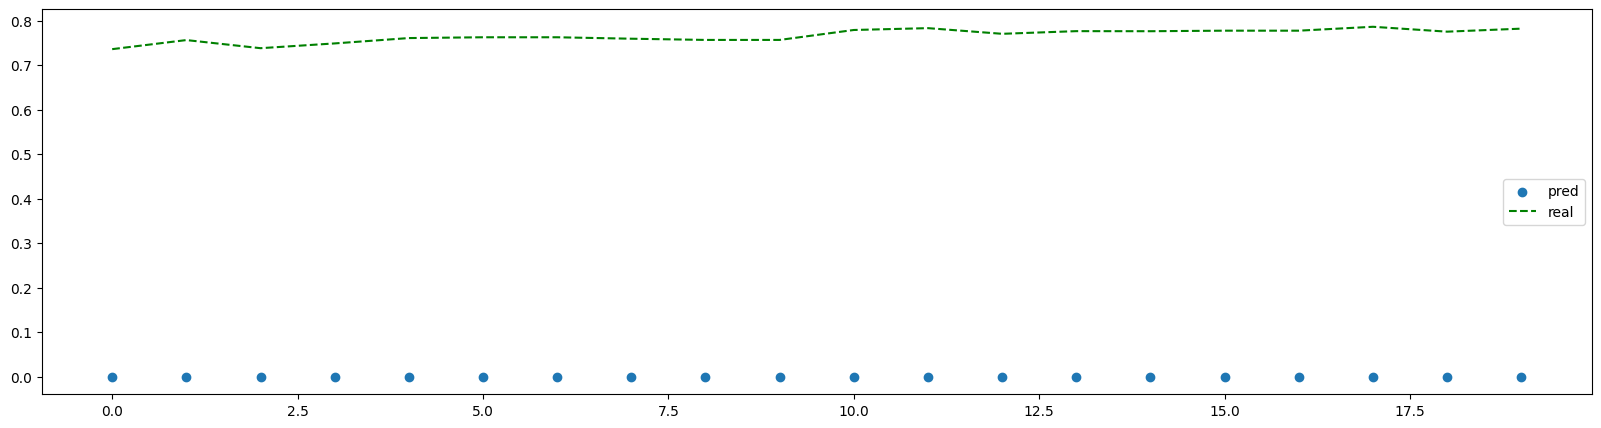

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-20: , 2], label='pred')
plt.plot(range(20), test_result.iloc[-20: , 1], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

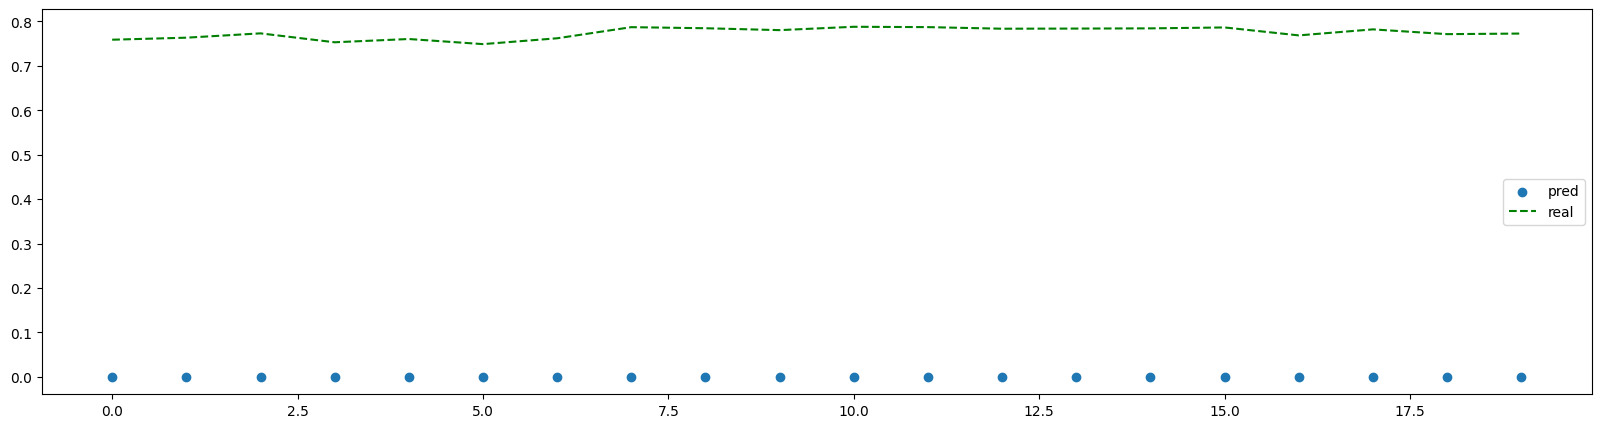

In [ ]:
plt.figure(figsize=(20, 5))
# plt.plot(idx_num, test_result['pred'], label='pred')
plt.scatter(range(20), test_result.iloc[-50:-30 , 2], label='pred')
plt.plot(range(20), test_result.iloc[-50:-30 , 1], 'g--', label='real')
# plt.scatter(range(len(test_result)), test_result['pred'], label='pred')
# plt.plot(range(len(test_result)), test_result['real'], 'g--', label='real')
plt.legend()
plt.show()

## 11. evaluation metrics
MAPE, MSE

In [ ]:
test_result['real'] = test_result['real'].astype('int')

In [ ]:
accuracy = accuracy_score(test_result['real'], test_result['pred_'])
precision = precision_score(test_result['real'], test_result['pred_'])
recall = recall_score(test_result['real'], test_result['pred_'])
cm = confusion_matrix(test_result['real'], test_result['pred_'])
print(f'ACC: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
print(cm)

ACC: 1.0000, Precision: 0.0000, Recall: 0.0000
[[140]]


c:\Users\alan.kwak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alan.kwak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alan.kwak\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:386: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


<Axes: >

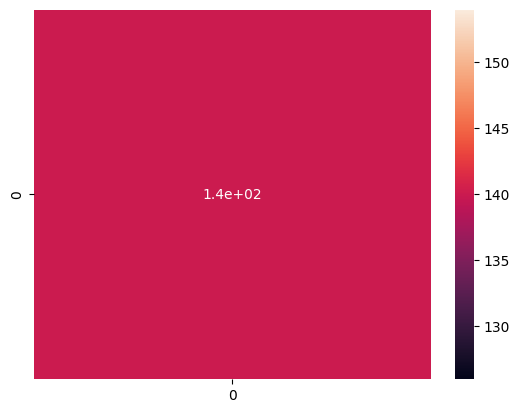

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True)